In [1]:
from songs import *

# НЕЙРОНКИ

In [2]:
import numpy as np
from numpy import random
import queue
import sys
from graphviz import Digraph

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
MEMORY_TIMES = 64  # сколько предыдущих моментов времени подаётся на вход
STARTER = 8        # сколько первых моментов времени берём для старта импровизации

ADDITIONAL_MEMORY = 8  # размер дополнительной памяти (в тек. версии - отметки о началах такта)

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY  # суммарный объём памяти

In [4]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]

NAMES = []  # названия входов
for i in range(8):  # отметки о долях идут первыми
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [69]:
class Edge:  # класс связи между нейронами
    def __init__(self, inp, outp, w, was_right=1, precedents=1):
        self.input = inp
        self.output = outp
        self.weight = w
        
        # важные статистики: количество верных ответов вида -1 и 1, и число прецендентов.
        self.was_right = was_right
        self.precedents = precedents
        
    def quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right / self.precedents

class Neuron:
    def __init__(self, index, name="", was_one=1, used=2, is_base=False):
        self.name = name        # название для отображения в графе
        
        self.index = index      # номер соответствует индексу в массиве нейронов сети. Это защита от циклов.
        self.is_base = is_base  # пометка, что это вход или выход, и трогать его нельзя
        
        self.inputs = []        # список входов
        self.outputs = []       # список выходов
        self.signal = 0         # сумма текущих входов
        
        # важная статистика: как часто нейрон выдаёт 1
        self.was_one = was_one   # сколько раз сигнал равнялся 1
        self.used = used        # сколько раз вообще проводился запуск
        
        # переменная для хранения качества сигнала
        self.signal_quality = 1
        
        # равно true, если этот нейрон внёс вклад в правильный ответ на каком-то выходе в текущем запуске
        self.success = False
        
    # вспомогательные функции
    def emitted(self):
        # значение выхода по сумме входов - пороговая функция по нулю
        if self.signal > 0:
            return 1
        return 0
    def getError(self):
        # ошибка в количестве голосов
        if self.signal > 0:
            return self.signal
        else:
            return 1 - self.signal
        
    def initialize(self):
        # инициализация перед запуском
        self.signal = 0
        self.signal_quality = 1
        self.success = False
    def emit(self, neurons):
        # функция "срабатывание" нейрона
        
        self.used += 1  # подсчёт статистик
        if self.signal > 0:
            self.was_one += 1
        
        if self.emitted() != 0:        
            for edge in self.outputs:  # перебор выходов
                edge.output.signal += edge.weight * self.emitted()  # добавление в сумму своего вклада

                # обновляем качество сигнала: оно равняется минимальному качеству входа, 
                # где качество входа - качество сигнала на входе * качество связи
                edge.output.signal_quality = min(edge.quality() * self.signal_quality, edge.output.signal_quality)   
                
    def reward(self, true_val, error_proba=1):
        # оценивание связи по известному правильному ответу
        
        if self.emitted() == true_val:  # если выдал нужный сигнал, помечаем нейрон как "не трожь!"
            self.success = True
                              
        for edge in self.inputs:
            input_val = edge.input.emitted()  # входной сигнал
            
            if input_val == 1:
                edge.precedents += 1 * error_proba
                if input_val * edge.weight == true_val:
                    edge.was_right += 1 * error_proba

                edge.input.reward(true_val * edge.weight, error_proba / self.getError())  # переходим во вход рекурсивно

In [111]:
class Func:
    def __init__(self):
        # нейроны-входы
        self.neurons = [Neuron(i, name=NAMES[i], was_one=0, used=1, is_base=True) for i in range(MEMORY_SIZE)]
        # нейроны-выходы
        for i in range(13):                                                                  
            self.neurons.append(Neuron(MEMORY_SIZE + i, name=NOTE_NAMES[i] + "outp", was_one=0, used=1, is_base=True)) 
        
        self.IDS = 0  # id нужны, чтобы различать нейроны, и давать имена скрытым нейронам.
        self.Random = np.random.RandomState(seed=179)  # рандом       
        self.verbose = False  # отладка
        self.level = 1
        
    def apply(self, x):  # проход по нейросети
        for neuron in self.neurons:
            neuron.initialize()
        
        # посылаем сигналы на нужные входы
        for i, val in enumerate(x):  
            if val == 1:
                self.neurons[i].signal += 1
        
        # запускаем нейроны
        for N in self.neurons:
            N.emit(self.neurons)
        
        # собираем включившиеся выходы
        return np.array([self.neurons[-13+i].emitted() == 1 for i in range(13)])
    
    def reward(self, true_vals):  # награждаем связи
        for i, val in enumerate(true_vals):
            if val == 1:
                self.neurons[-13+i].reward(1)
            else:
                self.neurons[-13+i].reward(-1)
            
    def forget_info(self):  # сбрасывание всех статистик - опциональная возможность. "Выучил выборку - пересчитай статистики".
        for N in self.neurons:
            for edge in N.inputs:
                edge.was_right = 1
                edge.precedents = 1
            
            if N.is_base:
                N.was_one = 0
                N.used = 1
            else:
                N.was_one = 1
                N.used = 2
    
    def randomOne(self, conseq):   # выбор случайного нейрона для создания гипотезы
        # гипотеза в данном контексте - это новая связь
        # гипотеза тем акутальнее, чем более специфично выбранное событие для текущей ситуации
        # то есть хочется выбрать гипотезу, которая срабатывает именно в этом запуске
        # для этого хочется взять событие, которое случилось в данном запуске, но его априорная вероятность очень мала
        # то есть выудить из текущего события какую-нибудь ценную информацию
        # поэтому вероятность выбора гипотезы пропорциональна 1 - P(события)
        
        candidates = []  # список нейронов-кандидатов
        proba = []       # список вероятностей, с котороыми мы их выберем
        
        # перебираем нейроны, стоящие в массиве до следствия, чтобы избежать циклов
        # также мы не берём выходы всей сети (последние 13 нейронов)
        for N in self.neurons[:min(len(self.neurons) - 13, conseq.index)]:
            # ВАЖНО! тут по идеи должна стоять защита от случая, 
            # что этот нейрон уже используется как вход для conseq. Однако...
            if N.emitted() == 1:
                candidates.append(N)
                proba.append(1 - N.was_one / N.used)
        
        # делаем случайный выбор
        proba = np.array(proba)
        proba /= proba.sum()
        return self.Random.choice(candidates, p=proba)
    
    def connect(self, N1, N2, w, was_right=1, precedents=1):
        # соединяем два нейрона новой связью; rewards-precedents это её исходная оценка
        if self.verbose:
            print("new edge (w=" + str(w) + ") between layers: ", N1.name, "(", N1.index, ")", " / ", N2.name, "(", N2.index, ")")
        NewEdge = Edge(N1, N2, w, was_right, precedents)
        N1.outputs.append(NewEdge)
        N2.inputs.append(NewEdge)
        return True
    
    def check_for_blow(self, neurons_queue):
        # нейрон отваливается, если у него нет входов или выходов
        # эта функция делает проверку очереди neurons_queue на такие нейроны
        # и уничтожает отвалившиеся
        
        while not neurons_queue.empty():
            N = neurons_queue.get()
            
            # проверяем нейрон; если у него нет входов или выходов, взрываем
            if N in self.neurons and not N.is_base: #возможно, он уже взорван
                if len(N.outputs) == 0:
                    if self.verbose:
                        print("neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.inputs[:]:
                        self.disconnect(edge, neurons_queue)
                elif len(N.inputs) == 0:
                    if self.verbose:
                        print("neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.outputs[:]:
                        self.disconnect(edge, neurons_queue)
                else:
                    continue
                
                # окончательное удаление из списка
                for neuron in self.neurons[N.index:]:
                    neuron.index -= 1
                self.neurons.remove(N)
                
    def disconnect(self, edge, neurons_queue=None):
        # разъединяем связь
        if self.verbose:
            print("remove edge between layers: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        edge.output.inputs.remove(edge)
        edge.input.outputs.remove(edge)
        
        # какие-то нейроны могли остаться без входов или выходов и их нужно взорвать: возвращаем очередь для проверки
        if neurons_queue is None:
            neurons_queue = queue.Queue()
        neurons_queue.put(edge.input)
        neurons_queue.put(edge.output)
        return neurons_queue
        
    def add_stub(self, edge):
        # добавление заглушки, т.е. нового нейрона в сеть
        # выбирается связь, по которой прошёл неверный сигнал, и разрывается нейроном
        # веса для двух новых связей выбираются так, чтобы произведение равнялось весу исходной связи
        # При этом варианта в любом случае два. Заведомо известно, что в стабе будет ошибка, 
        # а количество голосов будет -1 или 1 в зависимости от сигнала с единственного входа
        # Поскольку при 0 нейрон выдаёт -1, то проще 1 исправить в 0, чем -1 в 1
        # => выбираем тот вариант, при котором в стаб придёт сигнал 1
        
        # вычисление положения нейрона в сети. Он должен быть между входом и выходом разрываемой связи
        # и не задеть входной и выходной слой!
        stub_index = 1 + self.Random.randint(max(edge.input.index, MEMORY_SIZE - 1), min(len(self.neurons) - 13, edge.output.index))
        
        # Вообще-то, тут можно ещё вычислить априорную вероятность 1 для нового нейрона (соотв. вероятности единственного входа)
        # ну пока этого нет
        
        # добавление нейрона
        stub = Neuron(stub_index, name=str(self.IDS))
        self.IDS += 1
        
        for neuron in self.neurons[stub_index:]:  # индекс последующих нейронов смещается на единицу
            neuron.index += 1
        self.neurons.insert(stub_index, stub)
        
        stub.signal = edge.input.emitted()  # заполняем параметры текущего запуска для корректной работы
        stub.signal_quality = edge.input.signal_quality * edge.quality()
        
        if self.verbose:
            print("created stub (", stub_index, ") between: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        
        # решение уравнения на новые два веса: сигнал со входа; сигнал со входа на исходный вес.
        # при перемножении дадут исходный вес; в стаб придёт 1
        
        # изначальные оценки связей берём из разорванной связи?
        self.connect(edge.input, stub, 1)#, edge.was_right, edge.precedents)
        self.connect(stub, edge.output, edge.weight)#, edge.was_right, edge.precedents)
        self.disconnect(edge)
        
        return stub
        
    def turn(self, EndNeuron, wish):
        # АЛГОРИТМ ПОПРАВКИ!        
        operands = []
        wishes = []
        operation_proba = np.array([])
        
        candidates = []
        candidates_wishes = []
        
        BeginNeuron = EndNeuron
        current_wish = wish
        error_proba = 1
        while not BeginNeuron.success and BeginNeuron.index >= MEMORY_SIZE:            
            candidates.append(BeginNeuron)
            candidates_wishes.append(current_wish)
            
            paths = []
            paths_proba = []
            for edge in BeginNeuron.inputs:
                    if edge.input.emitted() * edge.weight != current_wish:
                        paths.append(edge)
                        paths_proba.append(1 - edge.quality() * edge.input.signal_quality)
            
            if len(paths) > 0:
                paths_proba = np.array(paths_proba)
                paths_proba /= paths_proba.sum()
                c = self.Random.choice(np.arange(len(paths)), p=paths_proba)
                #c = paths_proba.argmax()
                chosen_edge = paths[c]
                
                if self.Random.uniform(0, 1) < (1 - chosen_edge.quality())**self.level:
                    self.check_for_blow(self.disconnect(chosen_edge))
                    return
                
                operation_proba *= chosen_edge.quality()
                
                operands.append(chosen_edge)
                wishes.append(current_wish)
                operation_proba = np.append(operation_proba, chosen_edge.quality() * error_proba)
                               
                BeginNeuron = chosen_edge.input
                current_wish *= chosen_edge.weight
                error_proba *= chosen_edge.quality()                
            else:
                break
                
        for w, N in zip(candidates_wishes[::-1], candidates[::-1]):
            if N.getError() == 1:# and self.Random.uniform(0, 1) * len(N.inputs) < 1:
                one = self.randomOne(N)
                self.connect(one, N, w * one.emitted())
                return
                       
        index = operation_proba.argmax()#self.Random.choice(np.arange(len(operations)), p=operation_proba)
        operand = operands[index]
        wish = wishes[index]
        
        # Ошибка со связью. Строим стаб.
        stub = self.add_stub(operand)
            
        one = self.randomOne(stub)
        self.connect(one, stub, -one.emitted())
    
    def draw(self):
        # рисуем нейросеть
        dot = Digraph(format='png')
        for N in self.neurons:
            if N.index < MEMORY_SIZE:
                dot.attr('node', shape='doublecircle')
            elif N.is_base:
                dot.attr('node', shape='circle', color='green')
            else:
                dot.attr('node', style='filled', color='lightblue')
                
            if len(N.outputs) > 0 or len(N.inputs) > 0:
                dot.node(label = N.name + "\nq={0:.2f},".format(N.signal_quality) + "\ne={0:.3f}".format(N.was_one / N.used), 
                         name = N.name, size='2')
        
        for N in self.neurons:
            for edge in N.inputs:
                c = "blue"
                if edge.weight == -1:
                    c = "red"
                dot.edge(edge.input.name, edge.output.name, color = c, 
                         label = "{0:.2f}".format(edge.was_right / edge.precedents))
        #dot.render(view=True)
        return dot

In [112]:
class Player:
    def __init__(self):
        self.play_note = Func()
           
    def learn_to_play(self, song_to_learn, verbose=False, learn=True, limit = -1):
        if limit == -1:
            limit = len(song_to_learn.notes)
        self.play_note.verbose = verbose
        
        # исходная память
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        
        # считаем ошибки
        errors = 0
        
        while t < limit:    
            # играем
            output = self.play_note.apply(memory)
            # награждаем связи
            self.play_note.reward(song_to_learn.notes[t])
            
            if verbose:
                print(output.astype(int))
            
            # ищем ошибки
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    if learn:  # дообучаемся: говорим исправиться на этом входе
                        if output[note] == 0:
                            self.play_note.turn(self.play_note.neurons[-13 + note], 1)
                        else:
                            self.play_note.turn(self.play_note.neurons[-13 + note], -1)
                    #return t
            
            # переходим к следующей итерации
            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
            
        return errors
    
    def improvise(self, starter, length=128):  # играет чё хочет
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = self.play_note.apply(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [113]:
player = Player()

In [114]:
kuznechik = Song('../basic midi/track (1).mid')

In [115]:
player.learn_to_play(kuznechik, verbose=True, limit=128)

[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=1) between layers:  E-2 ( 818 )  /  Aoutp ( 849 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=1) between layers:  A-10 ( 719 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=1) between layers:  E-10 ( 714 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0]
new edge (w=-1) between layers:  A-6 ( 771 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0]
new edge (w=1) between layers:  G#-6 ( 770 )  /  Eoutp ( 844 )
remove edge between layers:  A-10 ( 719 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0]
new edge (w=1) between layers:  E-2 ( 818 )  /  G#outp ( 848 )
new edge (w=-1) between layers:  A-12 ( 693 )  /  Aoutp ( 849 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 1 0 0 0]
new edge (w=-1) bet

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in less


63

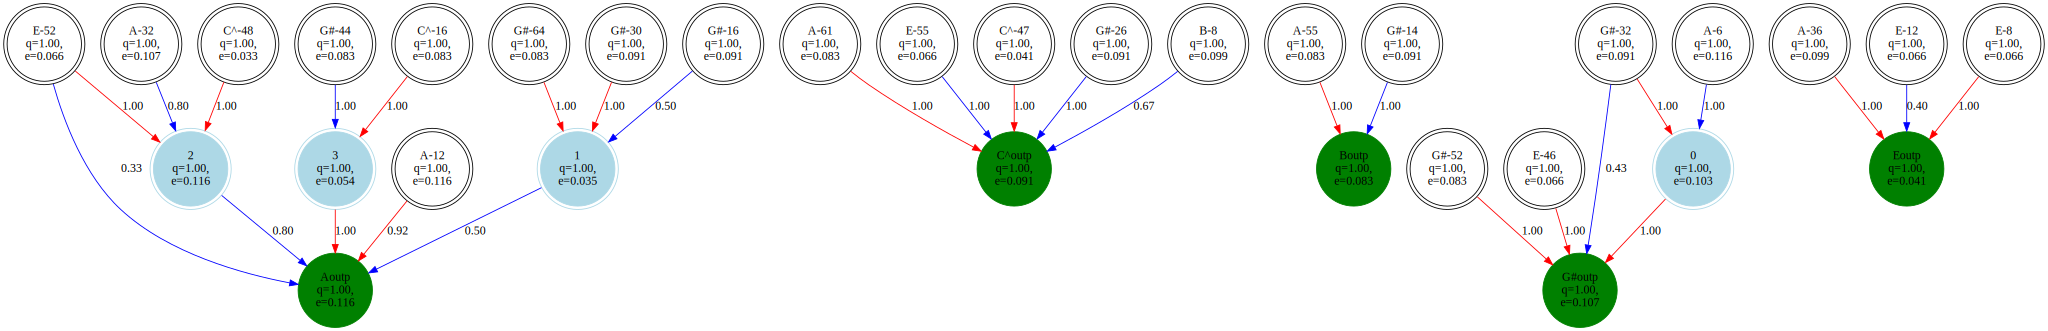

In [116]:
player.play_note.draw()

In [117]:
#player.play_note.draw().render("Адаптивно забывающий слон запомнил кузнечика (45 скрытых нейронов, финальный уровень 6,5)")

In [118]:
len(player.play_note.neurons[-4].inputs)

5

Взлетает на кузнечике на раз, в обоих вариантах обучения. Даже что-то играет (!!!)

Выбираем путь с вероятностью 1 - EQ * SQ, проводим удаление по текущей температуре. Если не удалили, ищем от начала сети нейроны на пути с единичной ошибкой, если вдруг нашли, то добавлям связь. Если нет, то равновероятно на пути выбираем место, где поставим заглушку. Результат: связей много. Полагаю, есть связи из одного и того же нейрона. EQ теперь - это успехи при выстреле, при ответе ноль мы ничего не оцениваем и ничего с нейроном не делаем.

Не масштабируется. Почему пока неясно (хотя явно очень плохой избыточный рост нейронов, т.е. эвристика температуры тут либо несбалансирована, либо не работает). Но вообще, результат какой-то интересный получился.

In [119]:
player = Player()

In [120]:
def stubs_input(F):
    return np.array([len(N.inputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()
def stubs_output(F):
    return np.array([len(N.outputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()

In [121]:
limit = 8
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]

while limit <= 128:#len(kuznechik.notes):
    player.play_note.forget_info()
    
    print("limit: ", limit, " neurons_at_start: ", len(player.play_note.neurons), " level: ", player.play_note.level)
    errors = [kuznechik.notes[:limit].sum()]
    while errors[-1] > 0:
        errors.append(player.learn_to_play(kuznechik, limit=limit))
        #if errors[-1] >= errors[-2]:
        #    player.play_note.level += 0.1
        #else:
        player.play_note.level += 0.01
        
        neurons.append(len(player.play_note.neurons))
        stubs_outputs.append(stubs_output(player.play_note))
        stubs_inputs.append(stubs_input(player.play_note))
               
        print(errors[-1], end=" ")
        sys.stdout.flush()
    player.play_note.level -= 0.1
    if player.play_note.level < 1:
        player.play_note.level = 1
    print("")
    limit += 1

limit:  8  neurons_at_start:  853  level:  1
0 
limit:  9  neurons_at_start:  853  level:  1
1 0 
limit:  10  neurons_at_start:  853  level:  1
0 
limit:  11  neurons_at_start:  853  level:  1
1 0 
limit:  12  neurons_at_start:  853  level:  1
0 
limit:  13  neurons_at_start:  853  level:  1
1 0 
limit:  14  neurons_at_start:  853  level:  1
0 
limit:  15  neurons_at_start:  853  level:  1
1 1 0 
limit:  16  neurons_at_start:  853  level:  1
0 
limit:  17  neurons_at_start:  853  level:  1
0 
limit:  18  neurons_at_start:  853  level:  1
0 
limit:  19  neurons_at_start:  853  level:  1
2 0 
limit:  20  neurons_at_start:  853  level:  1
0 
limit:  21  neurons_at_start:  853  level:  1
3 2 3 2 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in less


3 0 
limit:  22  neurons_at_start:  854  level:  1
0 
limit:  23  neurons_at_start:  854  level:  1
2 3 2 3 0 
limit:  24  neurons_at_start:  854  level:  1
0 
limit:  25  neurons_at_start:  854  level:  1
0 
limit:  26  neurons_at_start:  854  level:  1
0 
limit:  27  neurons_at_start:  854  level:  1
2 3 5 5 7 4 4 2 1 0 
limit:  28  neurons_at_start:  854  level:  1.0
0 
limit:  29  neurons_at_start:  854  level:  1
2 1 1 2 3 3 0 
limit:  30  neurons_at_start:  856  level:  1
0 
limit:  31  neurons_at_start:  856  level:  1
1 1 3 3 2 2 0 
limit:  32  neurons_at_start:  856  level:  1
0 
limit:  33  neurons_at_start:  856  level:  1
2 2 3 2 3 1 0 
limit:  34  neurons_at_start:  857  level:  1
0 
limit:  35  neurons_at_start:  857  level:  1
2 2 5 5 5 4 3 0 
limit:  36  neurons_at_start:  857  level:  1
0 
limit:  37  neurons_at_start:  857  level:  1
1 1 1 3 3 1 3 3 3 3 4 4 3 3 2 1 3 2 1 2 1 2 2 2 2 2 1 0 
limit:  38  neurons_at_start:  857  level:  1.1800000000000002
0 
limit:  39  n

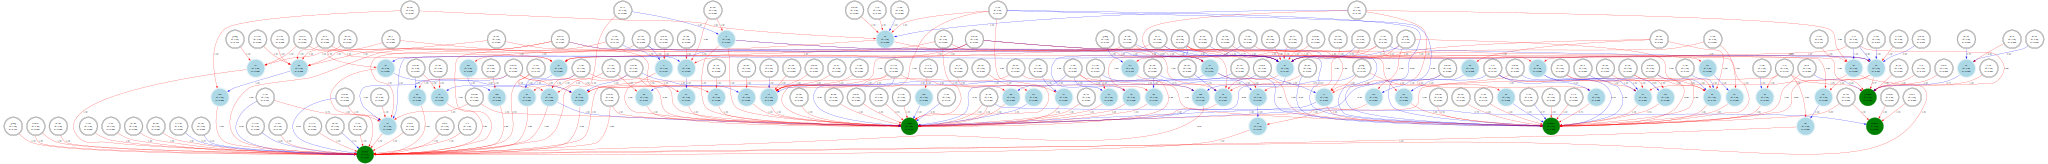

In [122]:
player.play_note.draw()

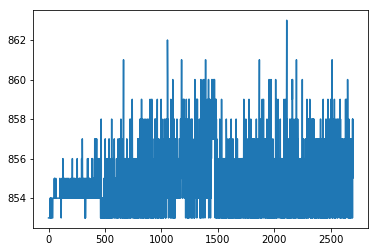

In [64]:
plt.plot(neurons)  # график количества нейронов в эпоху

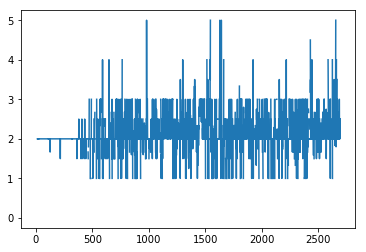

In [65]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

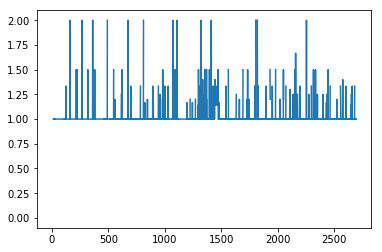

In [66]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

# Базовый вариант

In [127]:
player = Player()

In [128]:
errors = [kuznechik.notes.sum()]
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]

while errors[-1] > 0:
    errors.append(player.learn_to_play(kuznechik))
    if errors[-1] >= errors[-2]:
        player.play_note.level += 0.01
    
    neurons.append(len(player.play_note.neurons))
    stubs_outputs.append(stubs_output(player.play_note))
    stubs_inputs.append(stubs_input(player.play_note))
    print(errors[-1], end=" ")
    sys.stdout.flush()
    
    #if errors[-1] > errors[-2]:
    #    player.play_note.learning_rate += 1

63 73 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in less


77 58 74 61 47 41 42 41 45 32 30 28 25 21 25 35 29 34 20 22 21 15 13 16 18 18 17 19 20 19 9 16 18 22 16 17 15 16 16 14 12 17 16 14 18 14 22 16 20 15 11 13 15 12 14 15 15 11 11 11 10 9 12 8 2 6 8 8 10 9 14 9 9 8 12 20 10 19 12 14 10 12 16 16 14 12 8 11 10 12 12 10 11 7 10 10 5 6 7 3 2 3 2 3 4 3 5 4 4 4 3 4 1 1 2 4 5 4 0 

In [129]:
player.play_note.level

1.6500000000000006

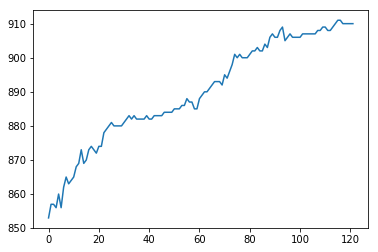

In [130]:
plt.plot(neurons)  # график количества нейронов в эпоху

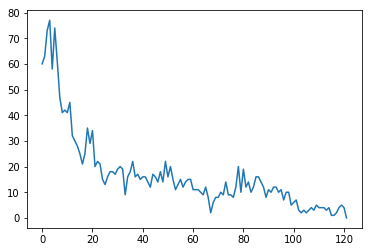

In [131]:
plt.plot(errors)  # график количества ошибок в эпоху

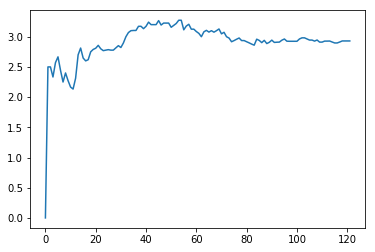

In [132]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

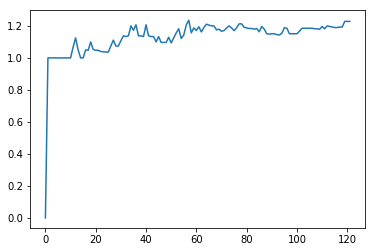

In [133]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

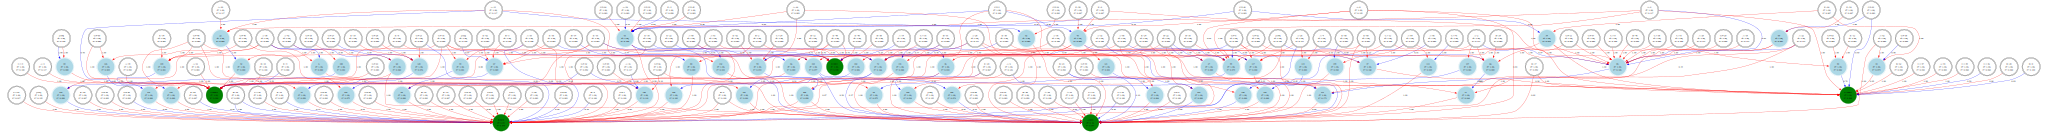

In [134]:
player.play_note.draw()

In [135]:
#player.play_note.draw().render('Бинарный слон') 

In [136]:
len(player.play_note.neurons)

910

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [137]:
player.improvise(kuznechik).play()

Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [138]:
simple_song = Song([9, 11, 12, 11, 9, 4, 5, 9])
result = player.improvise(simple_song)
result.play()

In [139]:
simple_song = Song('../basic midi/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [140]:
result.play()

## МНОГО ПЕСЕН

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [141]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [142]:
Songs = []
for i in range(1, 10):
    addAllTransposedVersions(Songs, Song('../basic midi/track (' + str(i) + ').mid'))

In [143]:
player = Player()

In [144]:
import random
random.shuffle(Songs)

prev_errors = np.array([Songs[i].notes.sum() for i in range(len(Songs))])
neurons = [len(player.play_note.neurons)]
levels = [player.play_note.level]

In [145]:
while prev_errors.sum() > 10:
    errors = []
    for i, song in enumerate(Songs):
        errors.append(player.learn_to_play(song))
        
        if errors[-1] >= prev_errors[i]:
            player.play_note.level += 0.1
        else:
            player.play_note.level -= 0.05            
        
        neurons.append(len(player.play_note.neurons))
        levels.append(player.play_note.level)
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    
    prev_errors = np.array(errors)
    print("sum = ", prev_errors.sum(), " level = ", levels[-1], " neurons = ", neurons[-1])

70 74 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in less


76 81 72 69 69 58 64 63 48 68 55 55 72 55 59 70 44 58 52 53 50 
sum =  1435  level =  3.1500000000000017  neurons =  1018
57 71 60 65 62 48 61 48 53 46 53 46 48 51 64 54 53 62 42 51 40 45 49 
sum =  1229  level =  2.1500000000000057  neurons =  1189
58 65 58 61 66 58 63 50 50 39 53 43 45 53 60 53 53 56 41 51 37 42 46 
sum =  1201  level =  2.350000000000009  neurons =  1369
52 54 53 60 60 57 59 48 50 44 55 51 43 53 65 53 52 60 46 53 37 40 50 
sum =  1195  level =  3.0000000000000115  neurons =  1547
57 72 67 63 58 65 51 41 46 41 52 46 43 51 57 49 56 66 44 49 35 49 52 
sum =  1210  level =  3.3500000000000147  neurons =  1774
55 58 64 61 66 55 51 52 55 48 50 51 48 56 68 52 66 63 44 51 39 39 48 
sum =  1240  level =  4.300000000000016  neurons =  1983
53 57 56 58 59 62 47 45 53 48 58 51 44 53 57 53 54 60 45 52 43 46 55 
sum =  1209  level =  4.650000000000015  neurons =  2234
59 65 58 81 68 56 51 48 44 43 57 47 42 54 67 52 54 70 49 54 41 48 51 
sum =  1259  level =  5.600000000000011  ne

KeyboardInterrupt: 

In [373]:
len(player.play_note.neurons)

1134

In [196]:
simple_song = Song('../basic midi/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

KeyboardInterrupt: 

In [143]:
result.save_file("181. Binary Elephant NN learned kuznechik (94 hidden neurons)")

In [144]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [145]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()